In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings 
warnings.filterwarnings("ignore")

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")

# Store our passenger ID for easy access
PassengerId = test["PassengerId"]

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
full_data = [train, test]

train["Name_length"] = train["Name"].apply(len)
test["Name_length"] = test["Name"].apply(len)

train["Has_Cabin"] = train["Cabin"].apply(lambda x : 0 if type(x) == float else 1)
test["Has_Cabin"] = test["Cabin"].apply(lambda x : 0 if type(x) == float else 1)

for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

for dataset in full_data:
    dataset["IsAlone"] = dataset["FamilySize"].apply(lambda x : 1 if x == 1 else 0)

for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")

for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())

train["CategoricalFare"] = pd.qcut(train["Fare"], 4)

for dataset in full_data:
    age_avg = dataset["Age"].mean()
    age_std = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
    
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)

    
train["CategoricalAge"] = pd.cut(train["Age"], 5)

for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(lambda x : x.split(",")[1].split(".")[0].strip())

for dataset in full_data:
    dataset["Title"] = dataset["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset["Title"] = dataset["Title"].replace("Mlle", "Miss")
    dataset["Title"] = dataset["Title"].replace("Ms", "Miss")
    dataset["Title"] = dataset["Title"].replace("Mme", "Mrs")

for dataset in full_data:
    dataset["Sex"] = dataset["Sex"].map({"female" : 0, "male" : 1})
    
    # Mapping titles
    title_mapping = {"Mr" : 1, "Miss" : 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}
    dataset["Title"] = dataset["Title"].map(title_mapping)
    dataset["Title"] = dataset["Title"].fillna(0)
    
    dataset["Embarked"] = dataset["Embarked"].map({'S' : 0, 'C' : 1, 'Q' : 2}).astype(int)
    
    # Mapping Fare
    dataset.loc[dataset["Fare"] <= 7.91, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
    dataset.loc[dataset["Fare"] > 31, "Fare"] = 3
    dataset["Fare"] = dataset["Fare"].astype(int)
    
    # Mapping Age
    dataset.loc[dataset["Age"] <= 16, "Age"] = 0
    dataset.loc[(dataset["Age"] > 16) & (dataset["Age"] <= 32), "Age"] = 1
    dataset.loc[(dataset["Age"] > 32) & (dataset["Age"] <= 48), "Age"] = 2
    dataset.loc[(dataset["Age"] > 48) & (dataset["Age"] <= 64), "Age"] = 3
    dataset.loc[dataset["Age"] > 64, "Age"] = 4

In [4]:
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp"]
train = train.drop(drop_elements, axis = 1)
train = train.drop(["CategoricalAge", "CategoricalFare"], axis = 1)
test = test.drop(drop_elements, axis = 1)

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


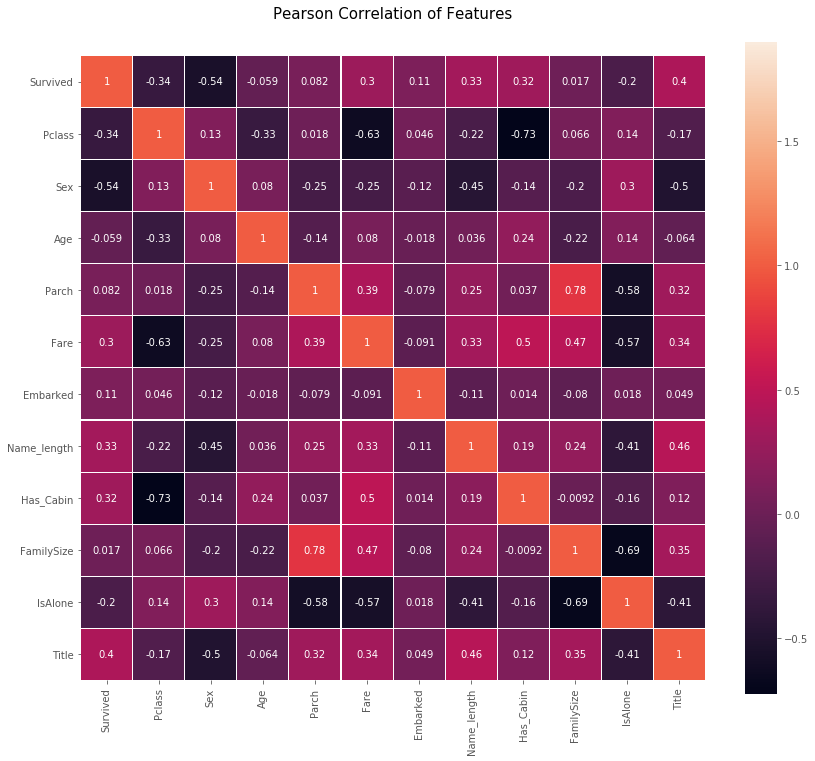

In [6]:
plt.figure(figsize = (14, 12))
plt.style.use("ggplot")
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(train.astype(float).corr(), linewidths = 0.1, vmax = 1.9, square = True, annot = True)

In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits = NFOLDS, random_state=SEED)

class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params["random_state"] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x, y).feature_importances_)

In [8]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [9]:
# put in our parameters for said classifiers
# Random Forest Parameters
rf_params = {
    "n_jobs" : -1,
    "n_estimators" : 500,
    "warm_start" : True,
    "max_depth" : 6,
    "min_samples_leaf" : 2,
    "max_features" : "sqrt",
    "verbose" : 0
}

# Extra Trees Parameters
et_params = {
    "n_jobs" : -1,
    "n_estimators" : 500,
    "max_depth" : 8,
    "min_samples_leaf" : 2,
    "verbose" : 0
}

# AdaBoost Parameters
ada_params = {
    "n_estimators" : 500,
    "learning_rate" : 0.75
}

# Gradient Boosting Parameters
gb_params = {
    "n_estimators" : 500,
    "max_depth" : 5,
    "min_samples_leaf" : 2,
    "verbose" : 0
}

# Support Vector Classifier Parameters
svc_params = {
    "kernel" : "linear",
    "C" : 0.025
}

In [10]:
rf = SklearnHelper(clf = RandomForestClassifier, seed = SEED, params = rf_params)
et = SklearnHelper(clf = ExtraTreesClassifier, seed = SEED, params = et_params)
ada = SklearnHelper(clf = AdaBoostClassifier, seed = SEED, params = ada_params)
gb = SklearnHelper(clf = GradientBoostingClassifier, seed = SEED, params = gb_params)
svc = SklearnHelper(clf = SVC, seed = SEED, params = svc_params)

In [11]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models

y_train = train["Survived"].ravel()
train = train.drop(["Survived"], axis = 1)
x_train = train.values
x_test = test.values

In [12]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)

rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
print("Training is complete")

Training is complete


In [13]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.12587256 0.19889337 0.03423226 0.02087111 0.070232   0.02375778
 0.10906765 0.06389575 0.06678622 0.01388666 0.27250463]
[0.12219864 0.38918394 0.0306103  0.01746456 0.05456119 0.02860997
 0.04710042 0.08332155 0.04462212 0.02132251 0.16100479]
[0.03  0.006 0.018 0.066 0.034 0.01  0.696 0.012 0.056 0.    0.072]
[0.09393004 0.01319656 0.05303057 0.01270275 0.0512794  0.0240301
 0.17261941 0.03560506 0.11120589 0.00547421 0.426926  ]


In [14]:
rf_features = [0.1262273,  0.20128571, 0.03048866, 0.02096054, 0.0719034,  0.02399064,
 0.10826677, 0.06526197, 0.06767423, 0.01338543, 0.27055535]
et_features = [0.12256091, 0.39287123, 0.02840594, 0.01658586, 0.05650491, 0.0280894,
 0.04676832, 0.08414396, 0.04244621, 0.02215095, 0.1594723]
ada_features = [0.032, 0.006, 0.022, 0.07,  0.038, 0.01,  0.676, 0.014, 0.052, 0.004, 0.076]
gb_features = [0.09387898, 0.00757619, 0.0490561,  0.01251328, 0.05531816, 0.02658653,
 0.1723166,  0.03997006, 0.11199686, 0.00447007, 0.42631718]

In [15]:
cols = train.columns.values

feature_dataframe = pd.DataFrame({
    "features" : cols,
    "Random Forest feature importances" : rf_features,
    "Extra Trees feature importances" : et_features,
    "AdaBoost feature importances" : ada_features,
    "Gradient Boost feature importances" : gb_features
})

In [16]:
feature_dataframe

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances
0,Pclass,0.126227,0.122561,0.032,0.093879
1,Sex,0.201286,0.392871,0.006,0.007576
2,Age,0.030489,0.028406,0.022,0.049056
3,Parch,0.020961,0.016586,0.070,0.012513
4,Fare,0.071903,0.056505,0.038,0.055318
5,Embarked,0.023991,0.028089,0.010,0.026587
6,Name_length,0.108267,0.046768,0.676,0.172317
7,Has_Cabin,0.065262,0.084144,0.014,0.039970
8,FamilySize,0.067674,0.042446,0.052,0.111997
9,IsAlone,0.013385,0.022151,0.004,0.004470


In [17]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [18]:
feature_dataframe["mean"] = feature_dataframe.mean(axis = 1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.126227,0.122561,0.032,0.093879,0.093667
1,Sex,0.201286,0.392871,0.006,0.007576,0.151933
2,Age,0.030489,0.028406,0.022,0.049056,0.032488


In [19]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [20]:
base_predictions_train = pd.DataFrame({
    "RandomForest" : rf_oof_train.flatten(),
    "ExtraTrees" : et_oof_train.flatten(),
    "AdaBoost" : ada_oof_train.flatten(),
    "GradientBoost" : gb_oof_train.flatten()
})
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [21]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [22]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis = 1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis = 1)

In [24]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                       max_depth=4,
                       min_child_weight = 2,
                       gamma = 0.9,
                       subsample = 0.8,
                       colsample_bytree = 0.8,
                       objective = "binary:logistic",
                       nthread = -1,
                       scale_pos_weight = 1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [25]:
StackingSubmission = pd.DataFrame({
    "PassengerId" : PassengerId,
    "Survived" : predictions
})
StackingSubmission.to_csv("StackingSubmission.csv", index = False)